# RNN and LSTM implementation by numpy

## Notation and format
- Superscripts $\langle t\rangle$ and $(i)$ denote time step and training example, respectively.
- $x$: input with shape $(n_x,m,T_x)$, where $n_x$ is the size of the vocabulary, $m$ is the number of training examples, and $T_x$ is the length of the input (e.g., number of words). For each training example and time step, the input is one-hot encoded vector of length $n_x$.
- $\hat{y}$: output predictions with shape $(n_y,m,T_x)$ (note that $T_y=T_x$ here), where $n_y$ is the number of classes in teh softmax output prediction.
- $a$: activations (hidden states) with shape $(n_a,m,T_x)$.

We denote the variables/parameters for a given timestep $t$ by $x^{\langle t\rangle}$, $\hat{y}^{\langle t\rangle}$, and $a^{\langle t\rangle}$ with shapes $(n_x,m)$, $(n_y,m)$, and $(n_a,m)$, respectively. 

# <span style="color:blue"> RNN </span>

## <span style="color:purple"> RNN cell </span>
Here we use numpy arrays to implement an RNN cell shown below:

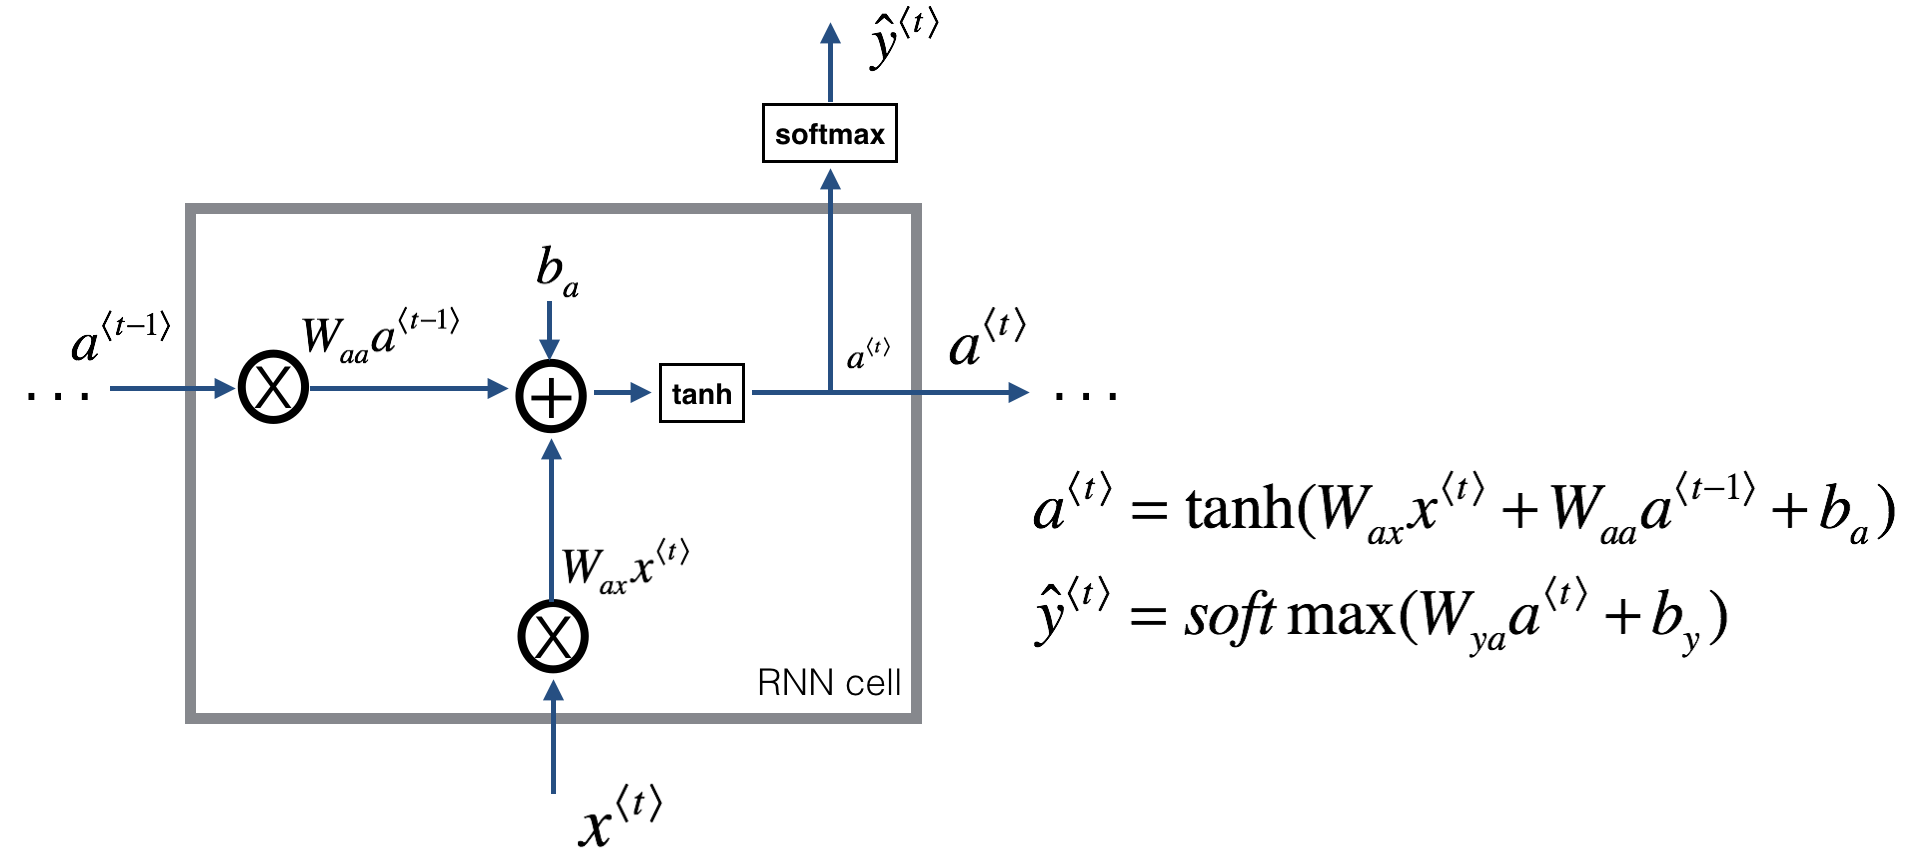

<center> Image taken directly from the course site </center>

**Notes:**
- $W_{ax}$ and $W_{aa}$ have shapes $(n_a,n_x)$ and $(n_a,n_a)$, respectively, so that $W_{ax}x^{\langle t\rangle}$ and $W_{aa}a^{\langle t-1\rangle}$ are both $(n_a,m)$. We will use `np.dot()` to compute these matrix products. $b_a$ is a one-dimensional vector with size $n_a$.
- The shape of $W_{ya}$ is $(n_y,n_a)$ and $b_y$ is a vector with size $n_y$.

In [1]:
import numpy as np
from tests import *
from scipy.special import softmax
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [2]:
def rnn_cell(xt, a_prev, params):
    """
    INPUT:
    xt: input data at timestep t; shape = (n_x, m).
    a_prev: hidden state at timestep t-1; shape = (n_a, m)
    params: hashmap:
                Wax: shape = (n_a, n_x)
                Waa: shape = (n_a, n_a)
                Wya: shape = (n_y, n_a)
                ba:  shape = (n_a, 1)
                by:  shape = (n_y, 1)
    OUTPUT:
    a_next: next hidden state; shape = (n_a, m)
    yt_pred: prediction at timestep t; shape = (n_y, m)
    cache: tuple of values needed for the backward pass; (a_next, a_prev, xt, params)
    """
    
    Wax = params["Wax"]
    Waa = params["Waa"]
    Wya = params["Wya"]
    ba = params["ba"]
    by = params["by"]
    
    a_next = np.tanh(np.dot(Waa,a_prev)+np.dot(Wax,xt)+ba)
    yt_pred = softmax(np.dot(Wya,a_next)+by,axis=0)
    cache = (a_next, a_prev, xt, params)
    
    return a_next, yt_pred, cache

In [3]:
# Tests taken directly from the course site with minor changes
np.random.seed(1)
xt_tmp = np.random.randn(3, 10)
a_prev_tmp = np.random.randn(5, 10)
parameters_tmp = {}
parameters_tmp['Waa'] = np.random.randn(5, 5)
parameters_tmp['Wax'] = np.random.randn(5, 3)
parameters_tmp['Wya'] = np.random.randn(2, 5)
parameters_tmp['ba'] = np.random.randn(5, 1)
parameters_tmp['by'] = np.random.randn(2, 1)

a_next_tmp, yt_pred_tmp, cache_tmp = rnn_cell(xt_tmp, a_prev_tmp, parameters_tmp)
print("a_next[4] = \n", a_next_tmp[4])
print("a_next.shape = \n", a_next_tmp.shape)
print("yt_pred[1] =\n", yt_pred_tmp[1])
print("yt_pred.shape = \n", yt_pred_tmp.shape)

# UNIT TESTS
rnn_cell_forward_tests(rnn_cell)

a_next[4] = 
 [ 0.59584544  0.18141802  0.61311866  0.99808218  0.85016201  0.99980978
 -0.18887155  0.99815551  0.6531151   0.82872037]
a_next.shape = 
 (5, 10)
yt_pred[1] =
 [0.9888161  0.01682021 0.21140899 0.36817467 0.98988387 0.88945212
 0.36920224 0.9966312  0.9982559  0.17746526]
yt_pred.shape = 
 (2, 10)
All tests passed


## <span style="color:purple"> RNN Forward Pass </span>
Now we stack $T_x$ RNN cells to make a sequence model (RNN is essentially the repeated use of a single cell):

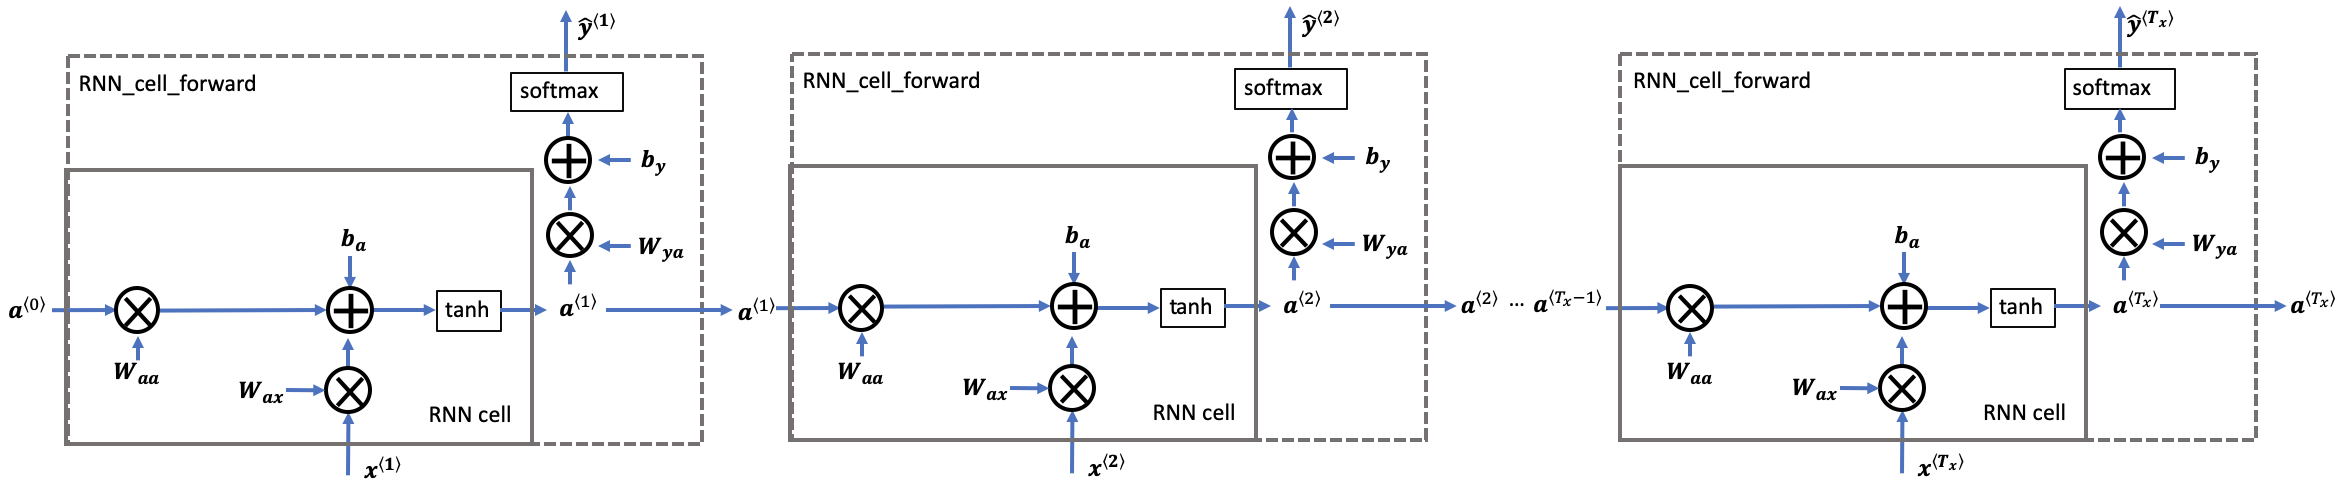

<center> Image taken directly from the course site </center>

**Notes:**
- Each cell gets $a^{\langle t-1\rangle}$ (shape: $(n_a,m)$) and $x^{\langle t\rangle}$ (shape: $(n_x,m)$) as inputs and outputs $a^{\langle t\rangle}$ (shape: $(n_a,m)$) and $\hat{y}^{\langle t\rangle}$ (shape: $(n_y,m)$).
- The weight matrices $W_{ax}\;(n_a,n_x), W_{aa}\;(n_a,n_a), b_a\;(n_a,1), W_{ya}\;(n_y,n_a), b_y\;(n_y,1)$ are the same for all cells.

In [4]:
def rnn_sequence(x, a0, params):
    """
    INPUT:
    x: input data; shape = (n_x, m, T_x)
    a0: initial hidden state; shape = (n_a, m)
    params: hashmap:
                Waa: shape = (n_a, n_a)
                Wax: shape = (n_a, n_x)
                Wya: shape = (n_y, n_a)
                ba:  shape = (n_a, 1)
                by:  shape = (n_y, 1)

    OUTPUT:
    a: hidden states; shape = (n_a, m, T_x)
    y_pred: predictions; shape = (n_y, m, T_x)
    """
    
    caches = []
    
    n_x, m, T_x = x.shape
    n_y, n_a = params["Wya"].shape
    
    a = np.zeros((n_a,m,T_x))
    y_pred = np.zeros((n_y,m,T_x))
    a_prev = a0
    for t in range(T_x):
        a_next, yt_pred, cache = rnn_cell(x[:,:,t], a_prev, params)
        a[:,:,t] = a_next
        y_pred[:,:,t] = yt_pred
        caches.append(cache)
        a_prev = a_next
    
    caches = (caches, x)
    
    return a, y_pred, caches

In [5]:
np.random.seed(1)
x_tmp = np.random.randn(3, 10, 4)
a0_tmp = np.random.randn(5, 10)
parameters_tmp = {}
parameters_tmp['Waa'] = np.random.randn(5, 5)
parameters_tmp['Wax'] = np.random.randn(5, 3)
parameters_tmp['Wya'] = np.random.randn(2, 5)
parameters_tmp['ba'] = np.random.randn(5, 1)
parameters_tmp['by'] = np.random.randn(2, 1)

a_tmp, y_pred_tmp, caches_tmp = rnn_sequence(x_tmp, a0_tmp, parameters_tmp)
print("a[4][1] = \n", a_tmp[4][1])
print("a.shape = \n", a_tmp.shape)
print("y_pred[1][3] =\n", y_pred_tmp[1][3])
print("y_pred.shape = \n", y_pred_tmp.shape)
print("caches[1][1][3] =\n", caches_tmp[1][1][3])
print("len(caches) = \n", len(caches_tmp))

#UNIT TEST    
rnn_forward_test(rnn_sequence)

a[4][1] = 
 [-0.99999375  0.77911235 -0.99861469 -0.99833267]
a.shape = 
 (5, 10, 4)
y_pred[1][3] =
 [0.79560373 0.86224861 0.11118257 0.81515947]
y_pred.shape = 
 (2, 10, 4)
caches[1][1][3] =
 [-1.1425182  -0.34934272 -0.20889423  0.58662319]
len(caches) = 
 2
All tests passed


# <span style="color:blue"> Lonf Short-Term Memory (LSTM) </span>

## <span style="color:purple"> LSTM cell </span>
We implement an LSTM cell shown below:

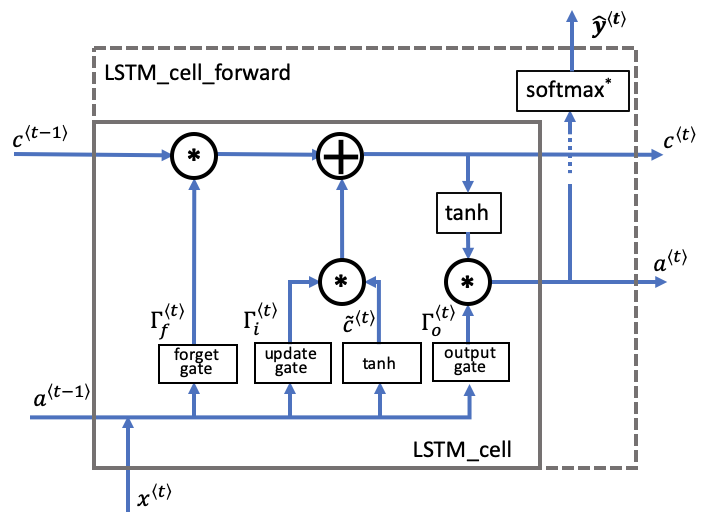

<center> Image taken directly from the course site </center>

### Gates
- forget gate: $\Gamma_f^{\langle t\rangle}=\sigma\left(W_fA+b_f\right)$
- update gate: $\Gamma_i^{\langle t\rangle}=\sigma\left(W_iA+b_i\right)$
- output gate: $\Gamma_o^{\langle t\rangle}=\sigma\left(W_oA+b_o\right)$

Here, the weight matrices $W_f$, $W_i$, and $W_o$ are constructed by stacking $W_{aa}$'s and $W_{ax}$'s horizontally. They all have the same shape $(n_a,n_a+n_x)$. The matrix $A$ is a concatenate of $a^{\langle t-1\rangle}$ and $x^{\langle t\rangle}$ and has the size $(n_a+n_x,m)$: $\begin{bmatrix} a^{\langle t-1 \rangle} & x^{\langle t \rangle} \end{bmatrix}^T$. The bias terms $b_f$, $b_i$, and $b_o$ are one-dimensional vectors with size $n_a$. Finally, $\sigma$ denotes the sigmoid function. Also, note that the gates have shape $(n_a,m)$.

The above diagram is rather straightforward to underatand. The other underlying calculations can be expressed as
- candidate value: $\tilde{c}^{\langle t\rangle}=\tanh\left(W_cA+b_c\right)$ where `W_c.shape=(n_a,n_a+n_x)` and `b_c.shape=(n_a,1)`.
- $c^{\langle t\rangle}=\Gamma_i^{\langle t\rangle}\cdot\tilde{c}^{\langle t\rangle}+\Gamma_f^{\langle t\rangle}\cdot c^{\langle t-1\rangle}$.
- $a^{\langle t\rangle}=\Gamma_o^{\langle t\rangle}\cdot\tanh\left(c^{\langle t\rangle}\right)$, where ''$\cdot$'' denotes element by element multiplication.
- $\hat{y}^{\langle t\rangle}=\mathrm{softmax}\left(W_ya^{\langle t\rangle}+b_y\right)$, where `W_y.shape=(n_y,n_a)` and `b_y.shape=(n_y,1)`.

In [6]:
def lstm_cell(xt, a_prev, c_prev, params):
    """
    INPUT:
    xt: input data at timestep t; shape = (n_x, m).
    a_prev: hidden state at timestep t-1; shape = (n_a, m)
    c_prev: memory state at timestep t-1; shape = (n_a, m)
    params: hashmap:
                Wf: shape = (n_a, n_a + n_x)
                bf: shape = (n_a, 1)
                Wi: shape = (n_a, n_a + n_x)
                bi: shape = (n_a, 1)
                Wo: shape = (n_a, n_a + n_x)
                bo: shape = (n_a, 1)
                Wc: shape = (n_a, n_a + n_x)
                bc: shape = (n_a, 1)
                Wy: shape = (n_y, n_a)
                by: shape = (n_y, 1)
                        
    OUTPUT:
    a_next: next hidden state; shape = (n_a, m)
    c_next: next memory state; shape = (n_a, m)
    yt_pred: prediction at timestep t; shape = (n_y, m)
    """
    
    Wf = params["Wf"]
    bf = params["bf"]
    Wi = params["Wi"]
    bi = params["bi"]
    Wo = params["Wo"]
    bo = params["bo"]
    Wc = params["Wc"]
    bc = params["bc"]
    Wy = params["Wy"]
    by = params["by"]
    
    n_x, m = xt.shape
    n_y, n_a = Wy.shape

    A = np.concatenate((a_prev,xt),axis=0)
    
    Gamma_f = sigmoid(np.dot(Wf,A)+bf)
    Gamma_i = sigmoid(np.dot(Wi,A)+bi)
    Gamma_o = sigmoid(np.dot(Wo,A)+bo)
    
    ctilde = np.tanh(np.dot(Wc,A)+bc)
    c_next = np.multiply(Gamma_i,ctilde)+np.multiply(Gamma_f,c_prev)
    
    a_next = np.multiply(Gamma_o,np.tanh(c_next))
    
    yt_pred = softmax(np.dot(Wy,a_next)+by,axis=0)

    cache = (a_next, c_next, a_prev, c_prev, Gamma_f, Gamma_i, ctilde, Gamma_o, xt, params)

    return a_next, c_next, yt_pred, cache

In [7]:
np.random.seed(1)
xt_tmp = np.random.randn(3, 10)
a_prev_tmp = np.random.randn(5, 10)
c_prev_tmp = np.random.randn(5, 10)
parameters_tmp = {}
parameters_tmp['Wf'] = np.random.randn(5, 5 + 3)
parameters_tmp['bf'] = np.random.randn(5, 1)
parameters_tmp['Wi'] = np.random.randn(5, 5 + 3)
parameters_tmp['bi'] = np.random.randn(5, 1)
parameters_tmp['Wo'] = np.random.randn(5, 5 + 3)
parameters_tmp['bo'] = np.random.randn(5, 1)
parameters_tmp['Wc'] = np.random.randn(5, 5 + 3)
parameters_tmp['bc'] = np.random.randn(5, 1)
parameters_tmp['Wy'] = np.random.randn(2, 5)
parameters_tmp['by'] = np.random.randn(2, 1)

a_next_tmp, c_next_tmp, yt_tmp, cache_tmp = lstm_cell(xt_tmp, a_prev_tmp, c_prev_tmp, parameters_tmp)

print("a_next[4] = \n", a_next_tmp[4])
print("a_next.shape = ", a_next_tmp.shape)
print("c_next[2] = \n", c_next_tmp[2])
print("c_next.shape = ", c_next_tmp.shape)
print("yt[1] =", yt_tmp[1])
print("yt.shape = ", yt_tmp.shape)
print("cache[1][3] =\n", cache_tmp[1][3])
print("len(cache) = ", len(cache_tmp))

# UNIT TEST
lstm_cell_forward_test(lstm_cell)

a_next[4] = 
 [-0.66408471  0.0036921   0.02088357  0.22834167 -0.85575339  0.00138482
  0.76566531  0.34631421 -0.00215674  0.43827275]
a_next.shape =  (5, 10)
c_next[2] = 
 [ 0.63267805  1.00570849  0.35504474  0.20690913 -1.64566718  0.11832942
  0.76449811 -0.0981561  -0.74348425 -0.26810932]
c_next.shape =  (5, 10)
yt[1] = [0.79913913 0.15986619 0.22412122 0.15606108 0.97057211 0.31146381
 0.00943007 0.12666353 0.39380172 0.07828381]
yt.shape =  (2, 10)
cache[1][3] =
 [-0.16263996  1.03729328  0.72938082 -0.54101719  0.02752074 -0.30821874
  0.07651101 -1.03752894  1.41219977 -0.37647422]
len(cache) =  10
All tests passed


## <span style="color:purple"> LSTM Forward Pass </span>

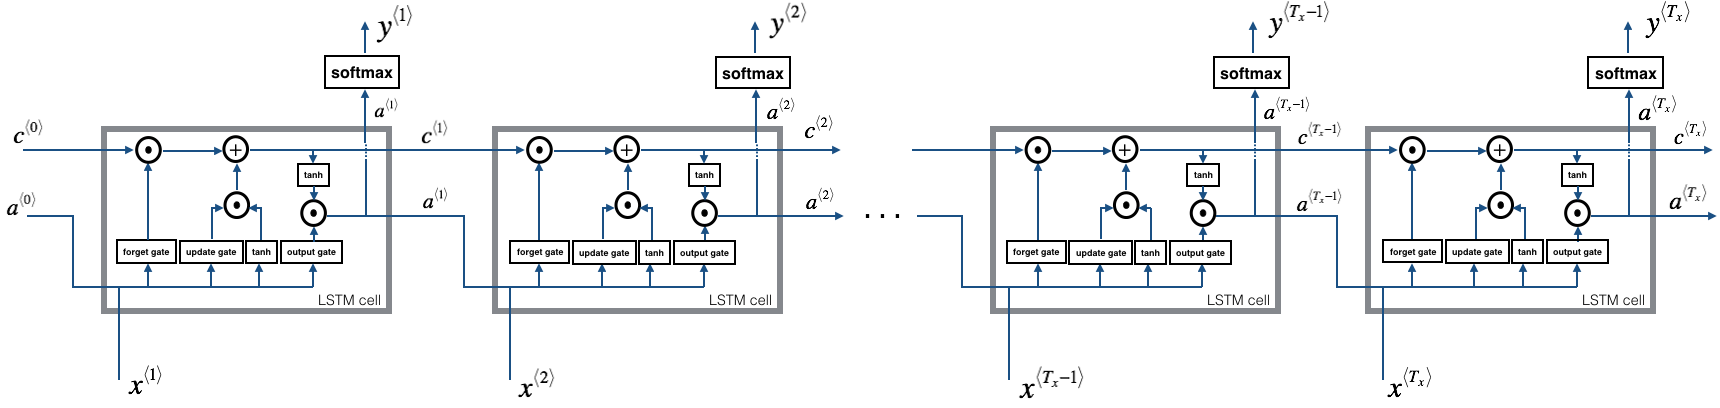

<center> Image taken directly from the course site </center>

In [8]:
def lstm_sequence(x, a0, parameters):
    """
    INPUT:
    INPUT:
    x: input data; shape = (n_x, m, T_x)
    a0: initial hidden state; shape = (n_a, m)
    params: hashmap:
                Wf: shape = (n_a, n_a + n_x)
                bf: shape = (n_a, 1)
                Wi: shape = (n_a, n_a + n_x)
                bi: shape = (n_a, 1)
                Wo: shape = (n_a, n_a + n_x)
                bo: shape = (n_a, 1)
                Wc: shape = (n_a, n_a + n_x)
                bc: shape = (n_a, 1)
                Wy: shape = (n_y, n_a)
                by: shape = (n_y, 1)
    
    OUTPUT:
    a: hidden states; shape = (n_a, m, T_x)
    c: memory states; shape = (n_a, m, T_x)
    y_pred: predictions; shape = (n_y, m, T_x)
    """
    
    caches = []
    
    n_x, m, T_x = x.shape
    n_y, n_a = parameters['Wy'].shape
    
    a = np.zeros((n_a,m,T_x))
    c = np.zeros((n_a,m,T_x))
    y_pred = np.zeros((n_y,m,T_x))
    
    a_next = a0
    c_next = np.zeros((n_a,m))
    
    for t in range(T_x):
        a_next, c_next, yt_pred, cache = lstm_cell(x[:,:,t], a_next, c_next, parameters)
        a[:,:,t] = a_next
        c[:,:,t]  = c_next
        y_pred[:,:,t] = yt_pred
        caches.append(cache)
        
    caches = (caches, x)

    return a, y_pred, c, caches

In [9]:
np.random.seed(1)
x_tmp = np.random.randn(3, 10, 7)
a0_tmp = np.random.randn(5, 10)
parameters_tmp = {}
parameters_tmp['Wf'] = np.random.randn(5, 5 + 3)
parameters_tmp['bf'] = np.random.randn(5, 1)
parameters_tmp['Wi'] = np.random.randn(5, 5 + 3)
parameters_tmp['bi']= np.random.randn(5, 1)
parameters_tmp['Wo'] = np.random.randn(5, 5 + 3)
parameters_tmp['bo'] = np.random.randn(5, 1)
parameters_tmp['Wc'] = np.random.randn(5, 5 + 3)
parameters_tmp['bc'] = np.random.randn(5, 1)
parameters_tmp['Wy'] = np.random.randn(2, 5)
parameters_tmp['by'] = np.random.randn(2, 1)

a_tmp, y_tmp, c_tmp, caches_tmp = lstm_sequence(x_tmp, a0_tmp, parameters_tmp)
print("a[4][3][6] = ", a_tmp[4][3][6])
print("a.shape = ", a_tmp.shape)
print("y[1][4][3] =", y_tmp[1][4][3])
print("y.shape = ", y_tmp.shape)
print("caches[1][1][1] =\n", caches_tmp[1][1][1])
print("c[1][2][1]", c_tmp[1][2][1])
print("len(caches) = ", len(caches_tmp))

# UNIT TEST    
lstm_forward_test(lstm_sequence)

a[4][3][6] =  0.1721177675329167
a.shape =  (5, 10, 7)
y[1][4][3] = 0.9508734618501101
y.shape =  (2, 10, 7)
caches[1][1][1] =
 [ 0.82797464  0.23009474  0.76201118 -0.22232814 -0.20075807  0.18656139
  0.41005165]
c[1][2][1] -0.8555449167181983
len(caches) =  2
All tests passed
